# Download and organize ENCODE data

```bash
# Path data (TODO: change to the path you want to store the data in)
path_data=/cellar/users/aklie/data/datasets/K562_ATAC-seq/data

# Download reference genome from ENCODE
wget https://www.encodeproject.org/files/GRCh38_no_alt_analysis_set_GCA_000001405.15/@@download/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz -O $path_data/hg38.fa.gz
gunzip $path_data/hg38.fa.gz

# Download reference chromosome sizes from ENCODE
wget https://www.encodeproject.org/files/GRCh38_EBV.chrom.sizes/@@download/GRCh38_EBV.chrom.sizes.tsv -O $path_data/hg38.chrom.sizes

# Download reference blacklist regions from ENCODE
wget https://www.encodeproject.org/files/ENCFF356LFX/@@download/ENCFF356LFX.bed.gz -O $path_data/blacklist.bed.gz
gunzip $path_data/blacklist.bed.gz

# download K562 ENCODE ATAC-seq peaks from ENCODE
wget https://www.encodeproject.org/files/ENCFF333TAT/@@download/ENCFF333TAT.bed.gz -O $path_data/ENCSR868FGK_K562_ATAC-seq_peaks.bed.gz
gunzip $path_data/ENCSR868FGK_K562_ATAC-seq_peaks.bed.gz

# remove blacklisted regions from peaks
bedtools slop -i blacklist.bed -g hg38.chrom.sizes -b 1057 > temp.bed
bedtools intersect -v -a $path_data/ENCSR868FGK_K562_ATAC-seq_peaks.bed -b $path_data/temp.bed > $path_data/ENCSR868FGK_K562_ATAC-seq_peaks_no_blacklist.bed

# download K562 ENCODE ATAC-seq bam for reps 1, 2, 3 from ENCODE
wget https://www.encodeproject.org/files/ENCFF077FBI/@@download/ENCFF077FBI.bam -O $path_data/ENCSR868FGK_K562_ATAC-seq_rep1.bam
wget https://www.encodeproject.org/files/ENCFF128WZG/@@download/ENCFF128WZG.bam -O $path_data/ENCSR868FGK_K562_ATAC-seq_rep2.bam
wget https://www.encodeproject.org/files/ENCFF534DCE/@@download/ENCFF534DCE.bam -O $path_data/ENCSR868FGK_K562_ATAC-seq_rep3.bam
```

# Create BigWig files w/ `chrombpnet`

```bash
# Path data (TODO: change to the path set above)
path_data=/cellar/users/aklie/data/datasets/K562_ATAC-seq/data

# Merge and sort bam files
samtools merge -f $path_data/merged_unsorted.bam $path_data/ENCSR868FGK_K562_ATAC-seq_rep1.bam $path_data/ENCSR868FGK_K562_ATAC-seq_rep2.bam $path_data/ENCSR868FGK_K562_ATAC-seq_rep3.bam
samtools sort -@4 $path_data/merged_unsorted.bam -o $path_data/merged.bam
samtools index $path_data/merged.bam

# use chrombpnet to get unstranded counts bigwig with correct shift (+4/-4)
script=/cellar/users/aklie/opt/chrombpnet/chrombpnet/helpers/preprocessing/reads_to_bigwig.py
cmd="python $script \
--genome $path_data/hg38.fa \
--input-bam-file $path_data/merged.bam \
--chrom-sizes $path_data/hg38.chrom.sizes \
--output-prefix $path_data/K562_ATAC-seq_merged \
--data-type ATAC"
echo $cmd
eval $cmd

# clean up intermediate files and rename K562_ATAC-seq_merged_unstranded.bw to K562_ATAC-seq_unstranded_counts.bw
mv $path_data/K562_ATAC-seq_merged_unstranded.bw $path_data/K562_ATAC-seq_unstranded_counts.bw 
rm $path_data/merged_unsorted.bam $path_data/merged.bam
```

# Get GC matched negatives with `tangermeme`

```bash
# Path data (TODO: change to the path set above)
path_data=/cellar/users/aklie/data/datasets/K562_ATAC-seq/data

# Get GC matched negatives
for i in {2..10}
do
    cmd="bpnet negatives \
-i $path_data/ENCSR868FGK_K562_ATAC-seq_peaks_no_blacklist.bed \
-f $path_data/hg38.fa \
-b $path_data/K562_ATAC-seq_unstranded_counts.bw \
-a 0.5 \
-n 0.1 \
-o $path_data/K562_ATAC-seq_negatives_run$i.bed \
-l 0.02 \
-w 2114 \
-x 1000 \
-v"
    echo $cmd
    eval $cmd
done

# Make version of negatives with distance to center for chrombpnet
awk '{mid = int(($2 + $3) / 2); distance = mid - $2; print $0, ".", ".", ".", ".", ".", ".", distance}' $path_data/K562_ATAC-seq_negatives.bed > $path_data/K562_ATAC-seq_negatives.chrombpnet.bed
```



In [1]:
import os
from tangermeme.match import extract_matching_loci

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# TODO: change to your path
data_dir = "/cellar/users/aklie/data/datasets/K562_ATAC-seq/data"

In [7]:
# Set-up all file paths
peaks = os.path.join(data_dir, "ENCSR868FGK_K562_ATAC-seq_peaks_no_blacklist.bed")
signal = os.path.join(data_dir, "K562_ATAC-seq_unstranded_counts.bw")
fasta = os.path.join(data_dir, "hg38.fa")
negatives = os.path.join(data_dir, "K562_ATAC-seq_negatives_run1.bed")

In [4]:
negative_loci = extract_matching_loci(
	loci=peaks,
	fasta=fasta,
	gc_bin_width=0.02,
	max_n_perc=0.1,
	bigwig=signal,
	signal_beta=0.5,
	in_window=2114,
	out_window=1000,
	chroms=None,
	random_state=1,
	verbose=True
)
negative_loci.to_csv(negatives, sep="\t", header=False, index=False)

Processing given loci.


Getting counts: 269717it [00:16, 16341.66it/s]
Getting N percentages: 269717it [00:03, 69264.87it/s]
Getting GC percentages: 269717it [00:05, 50522.26it/s]
Getting background GC: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


GC Bin	Background Count	Peak Count	Chosen Count
0.00:        0	       0	       0
0.02:        0	       0	       0
0.04:        1	       0	       0
0.06:        6	       0	       0
0.08:       11	       0	       0
0.10:       13	       0	       0
0.12:       18	       0	       0
0.14:       29	       0	       0
0.16:       41	       0	       0
0.18:       41	       0	       0
0.20:       70	       0	       0
0.22:      121	       2	       2
0.24:      226	       6	       6
0.26:     1347	      17	      17
0.28:     8092	      75	      75
0.30:    29435	     592	     592
0.32:    66071	    2396	    2396
0.34:   106629	    6509	    6509
0.36:   138630	   12035	   12035
0.38:   151451	   17613	   17613
0.40:   119890	   22134	   26681
0.42:    77406	   25014	   77406
0.44:    52201	   24774	   52201
0.46:    34255	   24133	   34255
0.48:    18634	   21803	   18634
0.50:     9043	   20066	    9043
0.52:     4457	   16977	    4457
0.54:     2567	   15183	    2567
0.56:     1719	   13310	    

Getting counts: 269691it [00:12, 22137.92it/s]


Peak Robust Signal Minimum: 207.0
Matched Signal Maximum: 103.0


# Make SeqDatas w/ `seqdata`

In [9]:
# Imports
import os
import numpy as np
import seqdata as sd
import xarray as xr

In [10]:
# Make output directory if doesn't exist
peaks_out = os.path.join(data_dir, "K562_ATAC-seq_peaks.zarr")
negatives_out = os.path.join(data_dir, "K562_ATAC-seq_negatives.zarr")
out = os.path.join(data_dir, "K562_ATAC-seq.zarr")
peaks_out, negatives_out

('/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_peaks.zarr',
 '/cellar/users/aklie/data/datasets/K562_ATAC-seq/data/K562_ATAC-seq_negatives.zarr')

In [11]:
# Build SeqData peaks
sdata_peaks = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=10000,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [signal],
        ["K562_ATAC-seq"],
        batch_size=10000,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=peaks_out,
    fixed_length=2114,
    bed=peaks,
    overwrite=True,
    max_jitter=128
)
sdata_peaks["type"] = "peak"
sdata_peaks.load()

100%|██████████| 269718/269718 [01:49<00:00, 2466.69it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 269718, cov_sample: 1, _length: 2370)
Coordinates:
  * cov_sample  (cov_sample) object 'K562_ATAC-seq'
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    blockCount  (_sequence) uint64 1291 89 688 479 1078 ... 101 93 246 127 235
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY' 'chrY'
    chromEnd    (_sequence) int64 100029914 100029914 ... 18994113 4032056
    chromStart  (_sequence) int64 100027544 100027544 ... 18991743 4029686
    cov         (_sequence, cov_sample, _length) float32 0.0 0.0 0.0 ... 0.0 0.0
    itemRgb     (_sequence) object '35.5667' '22.90134' ... '94.27854'
    ...          ...
    score       (_sequence) float64 375.0 247.0 212.0 ... 172.0 802.0 964.0
    seq         (_sequence, _length) |S1 b'A' b'C' b'A' b'G' ... b'T' b'T' b'C'
    strand      (_sequence) object '.' '.' '.' '.' '.' ... '.' '.' '.' '.' '.'
    thickEnd    (_sequence) int64 37 24 21 19 201 68 62 ... 79 18 54 21 17 80 96
    thickStart  (_sequence) int64 3 2 2 2 8 2 2 1 2 1 1 ... 3 10 3 5 2 4 3 2 5 6
    type        <U4 'peak'
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [12]:
# Build SeqData from negatives
sdata_neg = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=10000,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [signal],
        ["K562_ATAC-seq"],
        batch_size=10000,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=negatives_out,
    fixed_length=2114,
    bed=negatives,
    overwrite=True,
    max_jitter=128
)
sdata_neg["type"] = "negative"
sdata_neg.load()

100%|██████████| 269692/269692 [01:14<00:00, 3628.57it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 269692, cov_sample: 1, _length: 2370)
Coordinates:
  * cov_sample  (cov_sample) object 'K562_ATAC-seq'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY' 'chrY'
    chromEnd    (_sequence) int64 12812 14926 17040 ... 56883640 56887868
    chromStart  (_sequence) int64 10442 12556 14670 ... 56881270 56885498
    cov         (_sequence, cov_sample, _length) float32 0.0 1.0 1.0 ... 0.0 0.0
    seq         (_sequence, _length) |S1 b'C' b'T' b'A' b'A' ... b'A' b'T' b'T'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '+' '+' '+'
    type        <U8 'negative'
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [13]:
# Concatenate the two datasets
sdata = xr.concat([sdata_peaks, sdata_neg], dim="_sequence")
# https://github.com/pydata/xarray/issues/3476#issuecomment-1115045538
for v in list(sdata.coords.keys()):
    if sdata.coords[v].dtype == object:
        sdata.coords[v] = sdata.coords[v].astype("unicode")
for v in list(sdata.variables.keys()):
    if sdata[v].dtype == object:
        sdata[v] = sdata[v].astype("unicode")
sdata.to_zarr(out, mode='w')
sdata

<xarray.Dataset>
Dimensions:     (_sequence: 539410, cov_sample: 1, _length: 2370)
Coordinates:
  * cov_sample  (cov_sample) <U13 'K562_ATAC-seq'
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    blockCount  (_sequence) float64 1.291e+03 89.0 688.0 479.0 ... nan nan nan
    chrom       (_sequence) <U5 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY' 'chrY'
    chromEnd    (_sequence) int64 100029914 100029914 ... 56883640 56887868
    chromStart  (_sequence) int64 100027544 100027544 ... 56881270 56885498
    cov         (_sequence, cov_sample, _length) float32 0.0 0.0 0.0 ... 0.0 0.0
    itemRgb     (_sequence) <U11 '35.5667' '22.90134' '19.45153' ... 'nan' 'nan'
    ...          ...
    score       (_sequence) float64 375.0 247.0 212.0 198.0 ... nan nan nan nan
    seq         (_sequence, _length) |S1 b'A' b'C' b'A' b'G' ... b'A' b'T' b'T'
    strand      (_sequence) <U1 '.' '.' '.' '.' '.' '.' ... '+' '+' '+' '+' '+'
    thickEnd    (_sequence) float64 37.0 24.0 21.0 19.0 ... nan nan nan nan
    thickStart  (_sequence) float64 3.0 2.0 2.0 2.0 8.0 ... nan nan nan nan nan
    type        (_sequence) <U8 'peak' 'peak' 'peak' ... 'negative' 'negative'
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

# Some analyses

In [35]:
import seqpro as sp

from scipy.stats import ks_2samp

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Parameters
seq_len = 2114
target_len = 1000
max_jitter = 128
seqs_start = (sdata.dims["_length"] // 2) - (seq_len // 2)
counts_start = (sdata.dims["_length"] // 2) - (target_len // 2)
seqs_start, counts_start

(128, 685)

## GC content

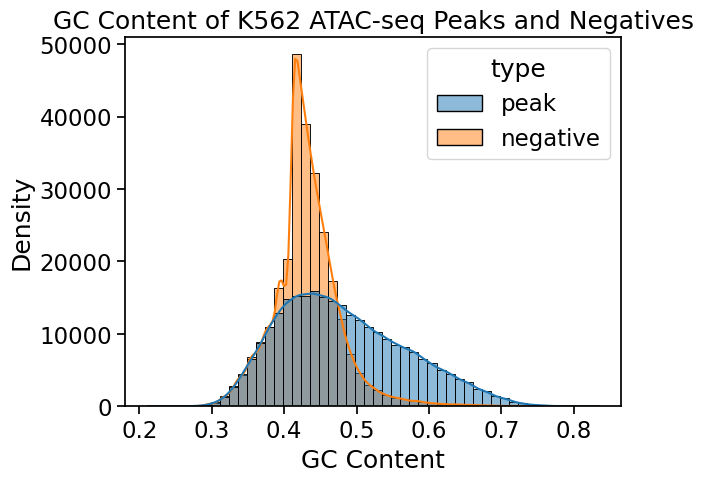

GC-bin KS test stat:0.351, p-value 0.0


In [16]:
gc_content = sp.gc_content(sdata["seq"].values[:, seqs_start:seqs_start+seq_len], length_axis=-1, alphabet=sp.DNA)
seq_df = sdata[["chrom", "chromStart", "chromEnd", "type"]].to_dataframe().assign(gc_content=gc_content)
with sns.plotting_context("notebook", font_scale=1.5):
    sns.histplot(seq_df, x="gc_content", hue="type", bins=50, kde=True)
    plt.xlabel("GC Content")
    plt.ylabel("Density")
    plt.title("GC Content of K562 ATAC-seq Peaks and Negatives")
    plt.show()
loci_gc = seq_df.query("type == 'peak'")["gc_content"].values
matched_gc = seq_df.query("type == 'negative'")["gc_content"].values
stats = ks_2samp(loci_gc, matched_gc)
print("GC-bin KS test stat:{:3.3}, p-value {:3.3}".format(stats.statistic, stats.pvalue))

## Percent Ns

In [32]:
n_max_percent = 0.2

In [ ]:
# Count the number of N's in each sequence
peak_seqs = sdata_peaks["seq"].values[:, seqs_start:seqs_start + seq_len]
peak_n_counts = np.sum(peak_seqs == b"N", axis=-1)
peak_n_percent = peak_n_counts / peak_seqs.shape[-1]

In [ ]:
# Count the number of N's in each sequence
neg_seqs = sdata_neg["seq"].values[:, seqs_start:seqs_start + seq_len]
neg_n_counts = np.sum(neg_seqs == b"N", axis=-1)
neg_n_percent = neg_n_counts / neg_seqs.shape[-1]

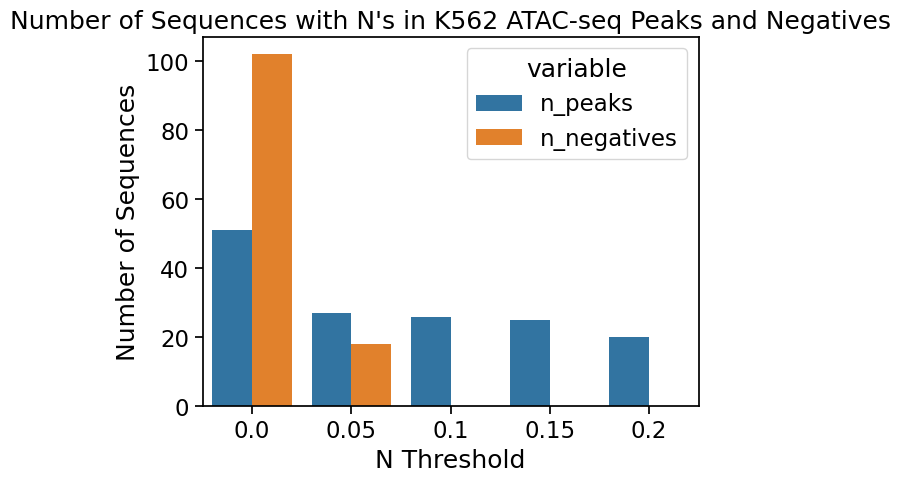

In [39]:
# barplot showing counts of N's over different thresholds of percent N's
n_bins = 5
n_thresholds = np.linspace(0, n_max_percent, n_bins)
peak_n_over_threshold = np.array([np.sum(peak_n_percent > t) for t in n_thresholds])
neg_n_over_threshold = np.array([np.sum(neg_n_percent > t) for t in n_thresholds])

n_df = pd.DataFrame({
    "n_threshold": n_thresholds,
    "n_peaks": peak_n_over_threshold,
    "n_negatives": neg_n_over_threshold
})

# round n_threshold to 2 decimal places
n_df["n_threshold"] = n_df["n_threshold"].round(2)

with sns.plotting_context("notebook", font_scale=1.5):
    sns.barplot(data=n_df.melt(id_vars="n_threshold"), x="n_threshold", y="value", hue="variable")
    plt.xlabel("N Threshold")
    plt.ylabel("Number of Sequences")
    plt.title("Number of Sequences with N's in K562 ATAC-seq Peaks and Negatives")
    plt.show()

## Summed counts

In [45]:
signal_beta = 0.5

In [40]:
peak_counts = sdata_peaks["cov"][..., counts_start:counts_start + target_len].sum(axis=(1,2)).values
log_peak_counts = np.log10(peak_counts + 1)
neg_counts = sdata_neg["cov"][..., counts_start:counts_start + target_len].sum(axis=(1,2)).values
log_neg_counts = np.log10(neg_counts + 1)

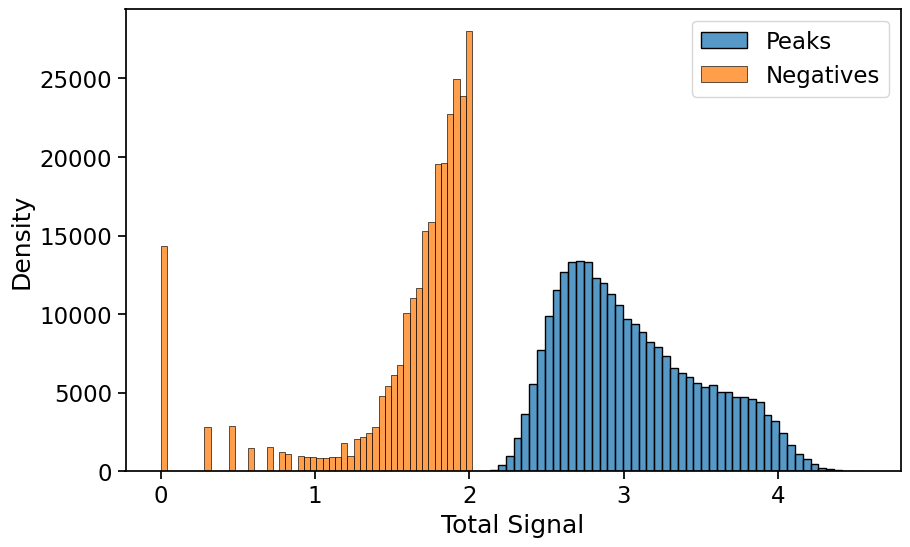

In [48]:
# Plot the distribution of peak and negative counts
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.histplot(log_peak_counts, bins=50, label="Peaks")
    sns.histplot(log_neg_counts, bins=50, label="Negatives")
    plt.xlabel("Total Signal")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [50]:
# 
robust_min = np.nanquantile(peak_counts, 0.01).item()
threshold = robust_min * signal_beta
neg_max = neg_counts.max()
print("Peak Robust Signal Minimum: {}".format(robust_min))
print("Matched Loci Maximum Threshold: {}".format(threshold))
print("Matched Signal Maximum: {}".format(neg_max))

Peak Robust Signal Minimum: 207.0
Matched Loci Maximum Threshold: 103.5
Matched Signal Maximum: 103.0


# Check against `pyBigWig`

In [53]:
import pyBigWig
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tracks(tracks, interval, height=1.5, colors=None):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [54]:
# The actual BigWig file
file = pyBigWig.open(str(signal))

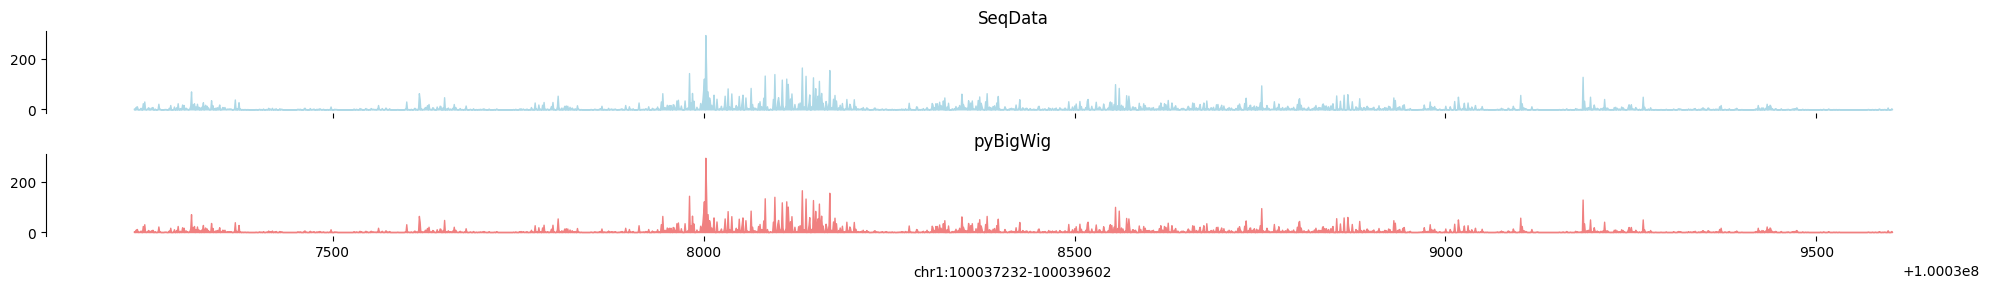

In [56]:
# Get data
seq_num = 10
ser = sdata_peaks[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
sdata_vals = sdata["cov"][seq_num].values.squeeze()
pybw_vals = np.nan_to_num(np.array(file.values(ser["chrom"], ser["chromStart"], ser["chromEnd"])))
chrom = ser["chrom"]
chromStart = ser["chromStart"]
chromEnd = ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "SeqData": sdata_vals,
    "pyBigWig": pybw_vals
}
colors = {
    "SeqData": "lightblue",
    "pyBigWig": "lightcoral"
}

# Plot tracks
plot_tracks(
    tracks=tracks,
    interval=interval,
    colors=colors
)

# DONE!

---

# Make SeqDataset

In [23]:
path_bw = sd.datasets.K562_ATAC_seq(type="bigwig")
path_bw

PosixPath('/cellar/users/aklie/.cache/seqdata/signal.bw')

In [24]:
path_seqdata = sd.datasets.K562_ATAC_seq(type="seqdata")
path_seqdata

# Testing against tangermeme

In [ ]:
from tangermeme.io import extract_loci

In [ ]:
_, peak_signal_tm = extract_loci(
    loci=peaks,
    sequences=fasta,
    signals=[signal],
    in_window=2370,
    out_window=1000,
    max_jitter=0,
    ignore=list('QWERYUIOPSDFHJKLZXVBNM'),
    verbose=True
)

Loading Loci: 100%|██████████| 269718/269718 [00:48<00:00, 5605.19it/s]


In [ ]:
peak_counts_tm = peak_signal_tm.sum(axis=(1,2))
peak_counts_tm

tensor([874., 874., 874.,  ..., 189., 221., 379.])

In [ ]:
from tangermeme.match import _counts_from_coords, _loci_coords_generator
import pandas as pd

In [ ]:
coords = _loci_coords_generator(sdata_peaks[["chrom", "chromStart", "chromEnd", "type"]].to_dataframe().rename(columns={"chromStart": "start", "chromEnd": "end"}), 1000)
matched_counts = _counts_from_coords(signal, coords, -1, buffer=False, verbose=True)
matched_counts[:25]

Getting counts: 0it [00:00, ?it/s]

Getting counts: 269718it [00:14, 18491.99it/s]


array([  874.,   874.,   874.,   874.,   874.,  1008.,  2802.,  2802.,
        2802., 10001., 10001., 10001., 10001., 10001., 10001.,   786.,
         786.,   586.,   586.,   582.,   526.,   526.,   526.,   506.,
         506.])

In [ ]:
coords = _loci_coords_generator(pd.read_csv(peaks, sep="\t", header=None, names=["chrom", "start", "end"]), 1000)
matched_counts = _counts_from_coords(signal, coords, -1, buffer=False, verbose=True)
matched_counts[:25]

Getting counts: 269718it [00:01, 219103.53it/s]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Getting counts: 269692it [00:11, 23471.69it/s]


103.0

In [ ]:
coords = _loci_coords_generator(sdata_neg[["chrom", "chromStart", "chromEnd", "type"]].to_dataframe().rename(columns={"chromStart": "start", "chromEnd": "end"}), 1000)

In [ ]:
matched_counts = _counts_from_coords(signal, coords, -1, buffer=False, verbose=True)
matched_counts.max()

Getting counts: 269692it [00:11, 23274.31it/s]


103.0

In [ ]:
coords = _loci_coords_generator(pd.read_csv(negatives, sep="\t", header=None, names=["chrom", "start", "end"]), 1000)

In [ ]:
matched_counts = _counts_from_coords(signal, coords, -1, buffer=False, verbose=True)
matched_counts.max()

Getting counts: 269692it [00:11, 23471.69it/s]


103.0

In [ ]:
matched_counts.shape

(269692,)

In [ ]:
neg_counts.shape

(269692,)

In [ ]:
matched_counts[:25]

array([ 3.,  5.,  4.,  0.,  2.,  3.,  0.,  5.,  6.,  2., 18., 10., 37.,
       38., 15.,  5.,  3.,  0.,  1.,  0.,  0.,  2., 37.,  8.,  1.])

In [ ]:
neg_counts[:25]

array([ 8.,  5.,  4.,  0.,  2.,  3.,  0.,  5.,  6.,  2., 19., 11., 36.,
       39., 19.,  6.,  3.,  1.,  1.,  1.,  0.,  2., 26.,  8.,  2.],
      dtype=float32)